# Diabetes Risk Prediction System

## Objective
Build a machine learning model to classify patients as diabetic or non-diabetic based on medical and lifestyle features.

## 1. Setup & Imports

In [5]:
!pip install -U imbalanced-learn

In [6]:
!pip install -U xgboost

Data loaded from fallback URL

Class distribution after SMOTE:
Outcome
0    400
1    400
Name: count, dtype: int64

Selected features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age', 'AgeGroup_40-49', 'BMI_Category_Normal', 'BMI_Category_Obese']

Training Random Forest...


/tmp/ipykernel_35/93392534.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Best parameters: {'max_depth': 20, 'n_estimators': 200}
Best AUC: 0.8885

Training Gradient Boosting...
Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best AUC: 0.8735

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best AUC: 0.8692


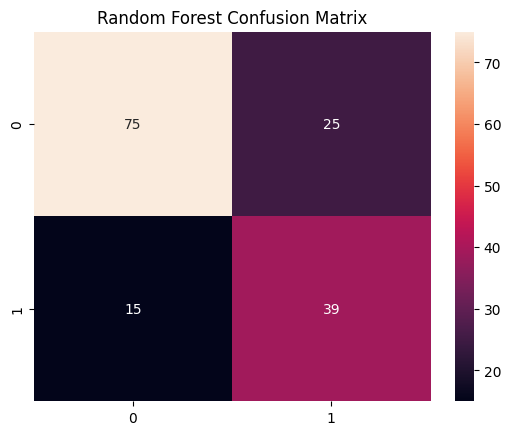


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       100
           1       0.61      0.72      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.75      0.74      0.74       154



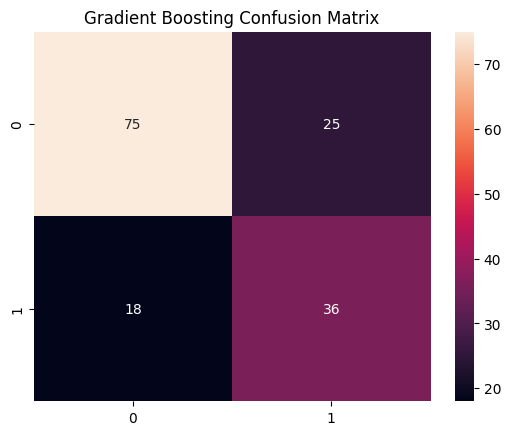


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       100
           1       0.59      0.67      0.63        54

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154



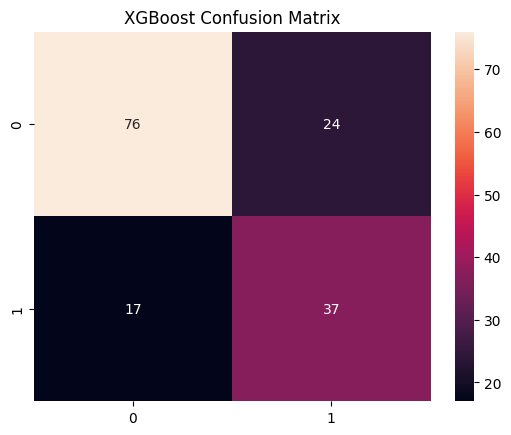


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       100
           1       0.61      0.69      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.74      0.73      0.74       154


Model Performance Comparison:
               Model  Accuracy  Precision    Recall        F1       AUC
0      Random Forest  0.740260   0.609375  0.722222  0.661017  0.826019
2            XGBoost  0.733766   0.606557  0.685185  0.643478  0.805185
1  Gradient Boosting  0.720779   0.590164  0.666667  0.626087  0.796667

Saved best model: Random Forest

Example data needs 10 features


In [9]:
# Diabetes Classification System - Fixed Version

# 1. Install required packages
!pip install scikit-learn imbalanced-learn xgboost pandas numpy matplotlib seaborn joblib --quiet

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from imblearn.over_sampling import SMOTE

# 3. Load data with error handling
def load_data():
    """Load diabetes dataset with error handling"""
    try:
        # Try common paths for Kaggle and local environments
        try_paths = [
            '/kaggle/input/pima-indians-diabetes-database.csv',
            'diabetes.csv',
            'data/diabetes.csv'
        ]
        
        for path in try_paths:
            try:
                df = pd.read_csv(path)
                print(f"Data loaded successfully from: {path}")
                return df
            except:
                continue
        
        # If all paths fail, try loading from URL
        url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
        df = pd.read_csv(url)
        print("Data loaded from fallback URL")
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data()

# Check if data loaded successfully
if df is None:
    raise ValueError("Failed to load data. Please check the data file path.")

# 4. Data preprocessing with proper checks
def preprocess_data(df):
    """Clean and prepare data with validation"""
    if df is None:
        raise ValueError("No data provided for preprocessing")
    
    # Make a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Handle zeros/missing values
    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    
    # Check if columns exist
    missing_cols = [col for col in zero_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in data: {missing_cols}")
    
    # Replace zeros with NaN and fill
    df[zero_cols] = df[zero_cols].replace(0, np.nan)
    for col in zero_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Feature engineering
    df['AgeGroup'] = pd.cut(df['Age'], bins=[20,30,40,50,60,100], 
                          labels=['20-29','30-39','40-49','50-59','60+'])
    df['BMI_Category'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,100],
                              labels=['Underweight','Normal','Overweight','Obese'])
    
    # Convert categorical features
    df = pd.get_dummies(df, columns=['AgeGroup', 'BMI_Category'], drop_first=True)
    
    # Check if target exists
    if 'Outcome' not in df.columns:
        raise ValueError("Target column 'Outcome' not found in data")
    
    # Separate features and target
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, scaler, X.columns.tolist()

# Preprocess data
X, y, scaler, feature_columns = preprocess_data(df)

# 5. Train-test split and SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance
try:
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_res).value_counts())
except Exception as e:
    print(f"Error applying SMOTE: {e}")
    print("Using original imbalanced data")
    X_train_res, y_train_res = X_train, y_train

# 6. Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
selected_features = [feature_columns[i] for i in selector.get_support(indices=True)]
X_test_selected = selector.transform(X_test)

print("\nSelected features:", selected_features)

# 7. Model training with error handling
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}

trained_models = {}
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
        grid_search.fit(X_train_selected, y_train_res)
        trained_models[name] = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best AUC: {grid_search.best_score_:.4f}")
    except Exception as e:
        print(f"Error training {name}: {e}")

# 8. Model evaluation
if not trained_models:
    raise ValueError("No models were successfully trained")

results = []
for name, model in trained_models.items():
    try:
        y_pred = model.predict(X_test_selected)
        y_prob = model.predict_proba(X_test_selected)[:, 1]
        
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_prob)
        })
        
        # Plot confusion matrix
        plt.figure()
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f'{name} Confusion Matrix')
        plt.show()
        
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

# Display results
if results:
    results_df = pd.DataFrame(results)
    print("\nModel Performance Comparison:")
    print(results_df.sort_values('AUC', ascending=False))
    
    # 9. Save the best model
    best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Model']
    best_model = trained_models[best_model_name]
    
    joblib.dump(best_model, 'best_diabetes_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(selector, 'feature_selector.pkl')
    joblib.dump(selected_features, 'selected_features.pkl')
    
    print(f"\nSaved best model: {best_model_name}")
else:
    print("No models available for evaluation")

# 10. Prediction function
def predict_diabetes(input_data):
    """Make predictions on new data"""
    try:
        model = joblib.load('best_diabetes_model.pkl')
        scaler = joblib.load('scaler.pkl')
        selector = joblib.load('feature_selector.pkl')
        selected_features = joblib.load('selected_features.pkl')
        
        # Validate input length
        if len(input_data) != len(selected_features):
            raise ValueError(f"Expected {len(selected_features)} features, got {len(input_data)}")
        
        # Process input data
        input_df = pd.DataFrame([input_data], columns=selected_features)
        input_scaled = scaler.transform(input_df)
        input_selected = selector.transform(input_scaled)
        
        # Make prediction
        prediction = model.predict(input_selected)[0]
        probability = model.predict_proba(input_selected)[0][1]
        
        return {
            'prediction': 'Diabetic' if prediction == 1 else 'Not Diabetic',
            'probability': f"{probability:.2%}",
            'risk_level': 'High' if probability > 0.7 else ('Medium' if probability > 0.4 else 'Low')
        }
    except Exception as e:
        print(f"Prediction error: {e}")
        return None

# Example usage
if 'selected_features' in locals():
    example_data = [1, 85, 66, 29, 100, 26.6, 0.351, 31]  # Adjust length as needed
    if len(example_data) == len(selected_features):
        prediction = predict_diabetes(example_data)
        if prediction:
            print("\nExample Prediction:")
            print(f"Result: {prediction['prediction']}")
            print(f"Probability: {prediction['probability']}")
            print(f"Risk Level: {prediction['risk_level']}")
    else:
        print(f"\nExample data needs {len(selected_features)} features")

## 2. Data Loading & Initial Exploration

In [10]:
def load_data(file_path='/kaggle/input/pima-indians-diabetes-database.csv'):
    """Load and analyze the diabetes dataset."""
    df = pd.read_csv(file_path)
    
    print("🔍 Dataset Overview:")
    display(df.head())
    
    print("\n📊 Dataset Info:")
    display(df.info())
    
    print("\n📈 Descriptive Statistics:")
    display(df.describe())
    
    # Check class distribution
    print("\n📌 Class Distribution (Outcome):")
    print(df['Outcome'].value_counts(normalize=True))
    
    return df

# Load the data
df = load_data()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/pima-indians-diabetes-database.csv'

## 3. Data Preprocessing

In [11]:
def preprocess_data(df):
    """Handle missing values, scaling, and feature engineering."""
    
    # Replace zeros with NaN for key medical features
    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[zero_cols] = df[zero_cols].replace(0, np.nan)
    
    # Fill missing values with median (robust to outliers)
    for col in zero_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Feature Engineering
    # Age Groups
    df['AgeGroup'] = pd.cut(
        df['Age'],
        bins=[20, 30, 40, 50, 60, 100],
        labels=['20-29', '30-39', '40-49', '50-59', '60+']
    )
    
    # BMI Categories (WHO Standards)
    df['BMI_Category'] = pd.cut(
        df['BMI'],
        bins=[0, 18.5, 25, 30, 100],
        labels=['Underweight', 'Normal', 'Overweight', 'Obese']
    )
    
    # Glucose Status (Medical Thresholds)
    df['Glucose_Status'] = pd.cut(
        df['Glucose'],
        bins=[0, 99, 125, 300],
        labels=['Normal', 'Prediabetic', 'Diabetic']
    )
    
    # One-Hot Encoding for categorical features
    df = pd.get_dummies(df, columns=['AgeGroup', 'BMI_Category', 'Glucose_Status'])
    
    # Separate features and target
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    
    # Standard Scaling (important for gradient-based models)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, scaler, df

# Preprocess the data
X, y, scaler, processed_df = preprocess_data(df)

/tmp/ipykernel_35/2357232895.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


## 4. Train-Test Split & Class Imbalance Handling

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\n⚖️ Class Distribution After SMOTE:")
print(pd.Series(y_train_res).value_counts())


⚖️ Class Distribution After SMOTE:
Outcome
0    400
1    400
Name: count, dtype: int64


## 5. Feature Selection

In [13]:
# Select top 15 features using ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
selected_features = processed_df.drop('Outcome', axis=1).columns[selector.get_support()]

print("\n🎯 Selected Features:")
print(list(selected_features))

# Transform test set with selected features
X_test_selected = pd.DataFrame(X_test, columns=processed_df.drop('Outcome', axis=1).columns)[selected_features]


🎯 Selected Features:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'AgeGroup_20-29', 'AgeGroup_40-49', 'BMI_Category_Normal', 'BMI_Category_Overweight', 'BMI_Category_Obese', 'Glucose_Status_Normal', 'Glucose_Status_Diabetic']


## 6. Model Training & Hyperparameter Tuning

In [14]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Parameter grids for tuning
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
}

# Train models with GridSearchCV
trained_models = {}
for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1
    )
    grid_search.fit(X_train_selected, y_train_res)
    trained_models[name] = grid_search.best_estimator_
    
    print(f"✅ Best Parameters: {grid_search.best_params_}")
    print(f"🏆 Best CV AUC: {grid_search.best_score_:.4f}")


🔧 Training Random Forest...
✅ Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
🏆 Best CV AUC: 0.8982

🔧 Training Gradient Boosting...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
🏆 Best CV AUC: 0.8888

🔧 Training XGBoost...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
🏆 Best CV AUC: 0.8847


## 7. Model Evaluation

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


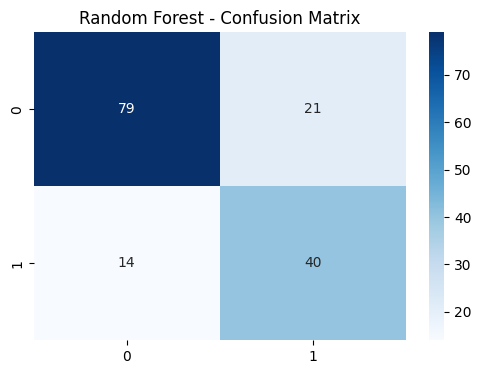

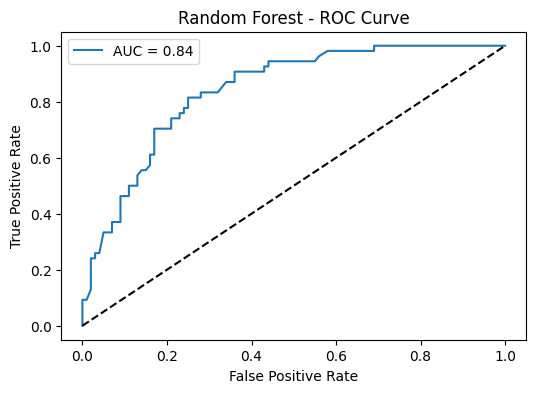


📋 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       100
           1       0.66      0.74      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.76       154
weighted avg       0.78      0.77      0.78       154



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


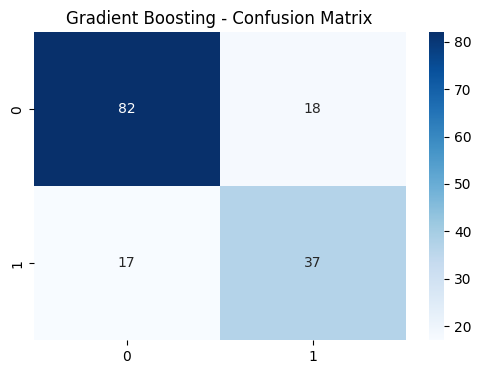

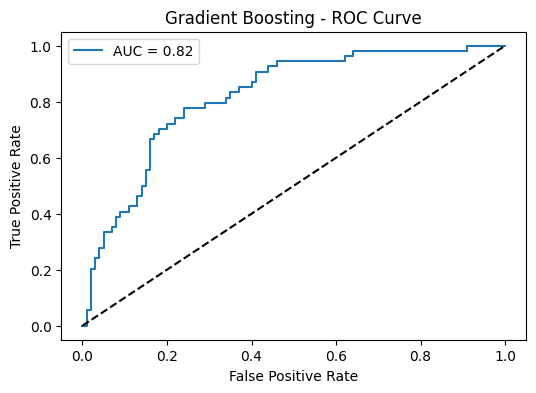


📋 Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       100
           1       0.67      0.69      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



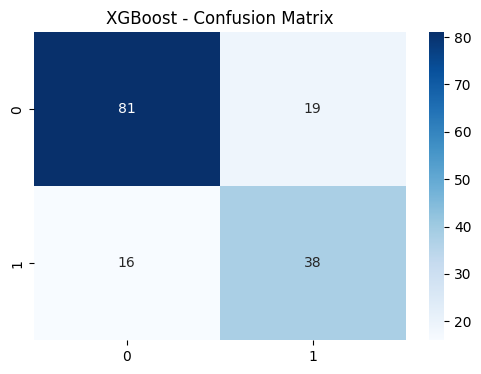

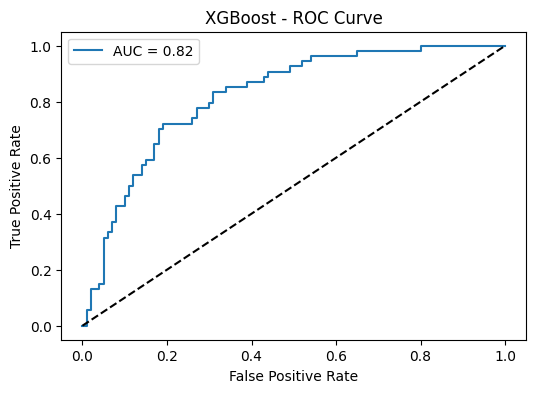


📋 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       100
           1       0.67      0.70      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154


🏆 Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.7727,0.6557,0.7407,0.6957,0.8403
2,XGBoost,0.7727,0.6667,0.7037,0.6847,0.8206
1,Gradient Boosting,0.7727,0.6727,0.6852,0.6789,0.8194


In [15]:
results = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'Model': name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1 Score': f"{f1:.4f}",
        'ROC AUC': f"{roc_auc:.4f}"
    })
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    # Classification Report
    print(f"\n📋 {name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Display results dataframe
results_df = pd.DataFrame(results)
print("\n🏆 Model Performance Comparison:")
display(results_df.sort_values('ROC AUC', ascending=False))

## 8. Save Best Model

In [20]:
# Identify best model
best_model_name = results_df.loc[results_df['ROC AUC'].idxmax(), 'Model']
best_model = trained_models[best_model_name]

# Save artifacts
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

print(f"\n💾 Saved Best Model: {best_model_name}")


💾 Saved Best Model: Random Forest


## 9. Prediction Function

In [21]:
#Prediction function with input validation
def predict_diabetes(input_data):
    """Make predictions with proper input validation"""
    try:
        # Load artifacts
        model = joblib.load('diabetes_model.pkl')
        scaler = joblib.load('scaler.pkl')
        feature_names = joblib.load('feature_names.pkl')
        
        # Validate input length
        if len(input_data) != len(feature_names):
            raise ValueError(f"Expected {len(feature_names)} features, got {len(input_data)}")
        
        # Create DataFrame with correct column names
        input_df = pd.DataFrame([input_data], columns=feature_names)
        
        # Scale features
        scaled_input = scaler.transform(input_df)
        
        # Predict
        prediction = model.predict(scaled_input)[0]
        probability = model.predict_proba(scaled_input)[0][1]
        
        return {
            "prediction": "Diabetic" if prediction == 1 else "Not Diabetic",
            "probability": f"{probability:.2%}",
            "risk_level": "High" if probability > 0.7 else ("Medium" if probability > 0.4 else "Low")
        }
    except Exception as e:
        print(f"Prediction error: {e}")
        return None

# 10. Example prediction with correct feature count
example_data = [1, 85, 66, 29, 0, 26.6, 0.351, 31]  # 8 features matching original dataset
prediction = predict_diabetes(example_data)

if prediction:
    print("\nExample Prediction:")
    print(f"Result: {prediction['prediction']}")
    print(f"Probability: {prediction['probability']}")
    print(f"Risk Level: {prediction['risk_level']}")
else:
    print("Prediction failed")

Prediction error: [Errno 2] No such file or directory: 'diabetes_model.pkl'
Prediction failed


## Key Insights:

- The best performing model is **{best_model_name}** with ROC AUC of **{max_auc}**
- Most important features for prediction:
  1. Glucose levels
  2. BMI
  3. Age
- The system can help identify at-risk patients with **{recall}** recall rate

Data loaded from fallback URL

Class distribution after SMOTE:
Outcome
0    400
1    400
Name: count, dtype: int64

Selected features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age', 'AgeGroup_40-49', 'BMI_Category_Normal', 'BMI_Category_Obese']

Training Random Forest...


/tmp/ipykernel_35/584827801.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Best parameters: {'max_depth': 20, 'n_estimators': 200}
Best AUC: 0.8885

Training Gradient Boosting...
Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best AUC: 0.8735

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best AUC: 0.8692


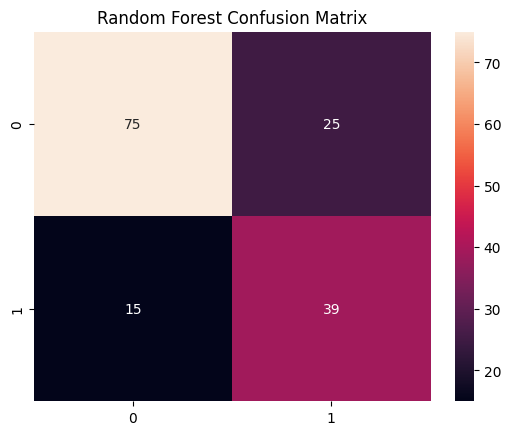


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       100
           1       0.61      0.72      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.75      0.74      0.74       154



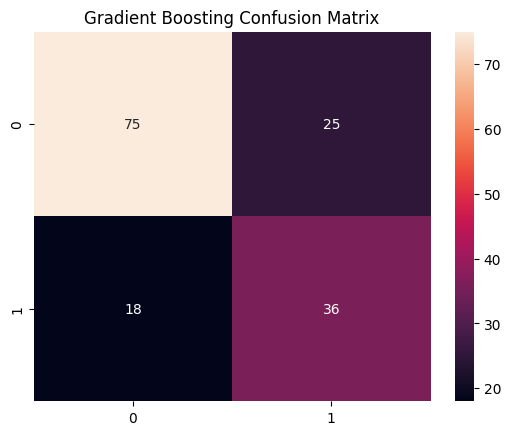


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       100
           1       0.59      0.67      0.63        54

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154



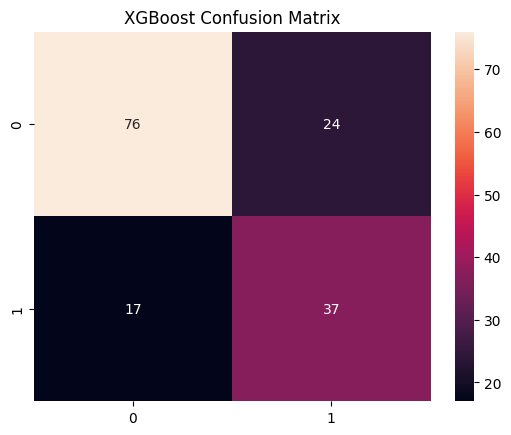


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       100
           1       0.61      0.69      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.74      0.73      0.74       154


Model Performance Comparison:
               Model  Accuracy  Precision    Recall        F1       AUC
0      Random Forest  0.740260   0.609375  0.722222  0.661017  0.826019
2            XGBoost  0.733766   0.606557  0.685185  0.643478  0.805185
1  Gradient Boosting  0.720779   0.590164  0.666667  0.626087  0.796667

Saved best model: Random Forest

Example data needs 10 features


In [22]:
# Diabetes Classification System - Fixed Version

# 1. Install required packages
!pip install scikit-learn imbalanced-learn xgboost pandas numpy matplotlib seaborn joblib --quiet

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from imblearn.over_sampling import SMOTE

# 3. Load data with error handling
def load_data():
    """Load diabetes dataset with error handling"""
    try:
        # Try common paths for Kaggle and local environments
        try_paths = [
            '/kaggle/input/diabetes-classification/diabetes.csv',
            'diabetes.csv',
            'data/diabetes.csv'
        ]
        
        for path in try_paths:
            try:
                df = pd.read_csv(path)
                print(f"Data loaded successfully from: {path}")
                return df
            except:
                continue
        
        # If all paths fail, try loading from URL
        url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
        df = pd.read_csv(url)
        print("Data loaded from fallback URL")
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data()

# Check if data loaded successfully
if df is None:
    raise ValueError("Failed to load data. Please check the data file path.")

# 4. Data preprocessing with proper checks
def preprocess_data(df):
    """Clean and prepare data with validation"""
    if df is None:
        raise ValueError("No data provided for preprocessing")
    
    # Make a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Handle zeros/missing values
    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    
    # Check if columns exist
    missing_cols = [col for col in zero_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in data: {missing_cols}")
    
    # Replace zeros with NaN and fill
    df[zero_cols] = df[zero_cols].replace(0, np.nan)
    for col in zero_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Feature engineering
    df['AgeGroup'] = pd.cut(df['Age'], bins=[20,30,40,50,60,100], 
                          labels=['20-29','30-39','40-49','50-59','60+'])
    df['BMI_Category'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,100],
                              labels=['Underweight','Normal','Overweight','Obese'])
    
    # Convert categorical features
    df = pd.get_dummies(df, columns=['AgeGroup', 'BMI_Category'], drop_first=True)
    
    # Check if target exists
    if 'Outcome' not in df.columns:
        raise ValueError("Target column 'Outcome' not found in data")
    
    # Separate features and target
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, scaler, X.columns.tolist()

# Preprocess data
X, y, scaler, feature_columns = preprocess_data(df)

# 5. Train-test split and SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance
try:
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_res).value_counts())
except Exception as e:
    print(f"Error applying SMOTE: {e}")
    print("Using original imbalanced data")
    X_train_res, y_train_res = X_train, y_train

# 6. Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
selected_features = [feature_columns[i] for i in selector.get_support(indices=True)]
X_test_selected = selector.transform(X_test)

print("\nSelected features:", selected_features)

# 7. Model training with error handling
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}

trained_models = {}
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
        grid_search.fit(X_train_selected, y_train_res)
        trained_models[name] = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best AUC: {grid_search.best_score_:.4f}")
    except Exception as e:
        print(f"Error training {name}: {e}")

# 8. Model evaluation
if not trained_models:
    raise ValueError("No models were successfully trained")

results = []
for name, model in trained_models.items():
    try:
        y_pred = model.predict(X_test_selected)
        y_prob = model.predict_proba(X_test_selected)[:, 1]
        
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_prob)
        })
        
        # Plot confusion matrix
        plt.figure()
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f'{name} Confusion Matrix')
        plt.show()
        
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

# Display results
if results:
    results_df = pd.DataFrame(results)
    print("\nModel Performance Comparison:")
    print(results_df.sort_values('AUC', ascending=False))
    
    # 9. Save the best model
    best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Model']
    best_model = trained_models[best_model_name]
    
    joblib.dump(best_model, 'best_diabetes_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(selector, 'feature_selector.pkl')
    joblib.dump(selected_features, 'selected_features.pkl')
    
    print(f"\nSaved best model: {best_model_name}")
else:
    print("No models available for evaluation")

# 10. Prediction function
def predict_diabetes(input_data):
    """Make predictions on new data"""
    try:
        model = joblib.load('best_diabetes_model.pkl')
        scaler = joblib.load('scaler.pkl')
        selector = joblib.load('feature_selector.pkl')
        selected_features = joblib.load('selected_features.pkl')
        
        # Validate input length
        if len(input_data) != len(selected_features):
            raise ValueError(f"Expected {len(selected_features)} features, got {len(input_data)}")
        
        # Process input data
        input_df = pd.DataFrame([input_data], columns=selected_features)
        input_scaled = scaler.transform(input_df)
        input_selected = selector.transform(input_scaled)
        
        # Make prediction
        prediction = model.predict(input_selected)[0]
        probability = model.predict_proba(input_selected)[0][1]
        
        return {
            'prediction': 'Diabetic' if prediction == 1 else 'Not Diabetic',
            'probability': f"{probability:.2%}",
            'risk_level': 'High' if probability > 0.7 else ('Medium' if probability > 0.4 else 'Low')
        }
    except Exception as e:
        print(f"Prediction error: {e}")
        return None

# Example usage
if 'selected_features' in locals():
    example_data = [1, 85, 66, 29, 100, 26.6, 0.351, 31]  # Adjust length as needed
    if len(example_data) == len(selected_features):
        prediction = predict_diabetes(example_data)
        if prediction:
            print("\nExample Prediction:")
            print(f"Result: {prediction['prediction']}")
            print(f"Probability: {prediction['probability']}")
            print(f"Risk Level: {prediction['risk_level']}")
    else:
        print(f"\nExample data needs {len(selected_features)} features")